In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops
from onepiece_64_utils import *
from onepiece_test_utils import *
#from keras.applications.imagenet_utils import preprocess_input
#from keras.preprocessing import image
#from matplotlib.pyplot import imshow

%matplotlib inline
np.random.seed(1)

/Users/naohi/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/naohi/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/naohi/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/naohi/.py

In [2]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

In [3]:
index = 92
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

y = 1


ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

In [4]:
X_train = X_train_orig/255.
X_test = X_test_orig/255.
Y_train = convert_to_one_hot(Y_train_orig, 3).T
Y_test = convert_to_one_hot(Y_test_orig, 3).T
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))
conv_layers = {}

number of training examples = 600
number of test examples = 237
X_train shape: (600, 64, 64, 3)
Y_train shape: (600, 3)
X_test shape: (237, 64, 64, 3)
Y_test shape: (237, 3)


In [5]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):

    X = tf.placeholder(tf.float32, shape=[None, n_H0, n_W0, n_C0])
    Y = tf.placeholder(tf.float32, shape=[None, n_y])

    return X, Y

In [6]:
def initialize_parameters():
        
    W1 = tf.get_variable('W1',[4, 4, 3, 8], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    W2 = tf.get_variable('W2',[2, 2, 8, 16], initializer = tf.contrib.layers.xavier_initializer(seed = 0))

    parameters = {"W1": W1,
                  "W2": W2}
    
    return parameters

In [7]:
def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    """
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    # CONV2D: stride of 1, padding 'SAME'
    Z1 = tf.nn.conv2d(X, W1, strides=[1, 1, 1, 1], padding='SAME')
    # RELU
    A1 = tf.nn.relu(Z1)
    # MAXPOOL: window 8x8, stride 8, padding 'SAME'
    P1 = tf.nn.max_pool(A1, ksize = [1, 8, 8, 1], strides = [1, 8, 8, 1], padding='SAME')
    # CONV2D: filters W2, stride 1, padding 'SAME'
    Z2 = tf.nn.conv2d(P1, W2, strides=[1, 1, 1, 1], padding='SAME')
    # RELU
    A2 = tf.nn.relu(Z2)
    # MAXPOOL: window 4x4, stride 4, padding 'SAME'
    P2 = tf.nn.max_pool(A2, ksize = [1, 4, 4, 1], strides = [1, 4, 4, 1], padding='SAME')
    # FLATTEN
    P = tf.contrib.layers.flatten(P2)
    # FULLY-CONNECTED without non-linear activation function (not not call softmax).
    # 6 neurons in output layer. Hint: one of the arguments should be "activation_fn=None" 
    Z3 = tf.contrib.layers.fully_connected(P, 3, activation_fn=None)

    return Z3

In [8]:
def compute_cost(Z3, Y):

    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Z3, labels=Y))
    
    return cost

In [26]:
def model(X_train, Y_train, X_test, Y_test, learning_rate=0.009, num_epochs=100, minibatch_size=64, print_cost=True):
    """
    Implements a three-layer ConvNet in Tensorflow:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep results consistent (tensorflow seed)
    seed = 3                                          # to keep results consistent (numpy seed)
    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = []                                        # To keep track of the cost
    step = 0
    # Create Placeholders of the correct shape
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)
    #x = tf.placeholder(tf.float32, shape=[None, 64, 64, 3])
    
    # Initialize parameters
    parameters = initialize_parameters()
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z3 = forward_propagation(X, parameters)

    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(Z3, Y)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer that minimizes the cost.
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    Z3_check = forward_propagation(x, parameters)
    
    # Initialize all the variables globally
    init = tf.global_variables_initializer()
    
    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)
            step += 1

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the optimizer and the cost, the feedict should contain a minibatch for (X,Y).
                _ , temp_cost = sess.run([optimizer, cost], feed_dict={X:minibatch_X, Y:minibatch_Y})
                
                minibatch_cost += temp_cost / num_minibatches
                
            # Print the cost every epoch
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
        
        
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # Calculate the correct predictions
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
            
        """
        print(parameters['W1'].eval())
        print(parameters['W2'].eval())
        """
        # save
        saver = tf.train.Saver()
        saver.save(sess, 'save/onepiece_tfmodel', global_step = step, write_meta_graph = False)
                
        return train_accuracy, test_accuracy, parameters, Z3_check

Cost after epoch 0: 1.200514
Cost after epoch 5: 1.037153
Cost after epoch 10: 0.960174
Cost after epoch 15: 0.790711
Cost after epoch 20: 0.713130
Cost after epoch 25: 0.639038
Cost after epoch 30: 0.568183
Cost after epoch 35: 0.475890
Cost after epoch 40: 0.429426
Cost after epoch 45: 0.350440
Cost after epoch 50: 0.355974
Cost after epoch 55: 0.280785
Cost after epoch 60: 0.251612
Cost after epoch 65: 0.216338
Cost after epoch 70: 0.177251
Cost after epoch 75: 0.142797
Cost after epoch 80: 0.128348
Cost after epoch 85: 0.105753
Cost after epoch 90: 0.093696
Cost after epoch 95: 0.076734


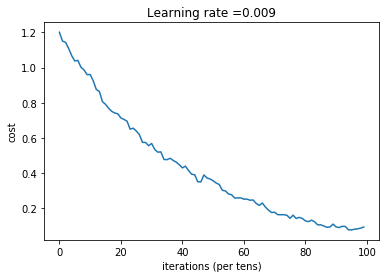

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.9716667
Test Accuracy: 0.98312235


In [27]:
_, _, parameters, Z3_check = model(X_train, Y_train, X_test, Y_test)

In [42]:
init = tf.global_variables_initializer()
X_check, Y_check, classes = load_test_dataset()
X_check = X_check / 255.
x = tf.placeholder(tf.float32, shape=[None, 64, 64, 3])
with tf.Session() as sess:
    sess.run(init)
    Z3 = forward_propagation(x, parameters)
    print(Z3.eval(feed_dict={x:X_check}, session=sess))

FailedPreconditionError: Attempting to use uninitialized value fully_connected_13/weights
	 [[node fully_connected_13/weights/read (defined at <ipython-input-7-680817177e31>:26) ]]

Original stack trace for 'fully_connected_13/weights/read':
  File "/Users/naohi/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/naohi/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/naohi/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/Users/naohi/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/traitlets/config/application.py", line 653, in launch_instance
    app.start()
  File "/Users/naohi/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/Users/naohi/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/Users/naohi/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/Users/naohi/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/naohi/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Users/naohi/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/naohi/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/naohi/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/naohi/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/naohi/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/naohi/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/Users/naohi/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/naohi/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/naohi/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/naohi/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/naohi/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-42-31ca0ce0fd46>", line 7, in <module>
    Z3 = forward_propagation(x, parameters)
  File "<ipython-input-7-680817177e31>", line 26, in forward_propagation
    Z3 = tf.contrib.layers.fully_connected(P, 3, activation_fn=None)
  File "/Users/naohi/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/tensorflow/contrib/framework/python/ops/arg_scope.py", line 182, in func_with_args
    return func(*args, **current_args)
  File "/Users/naohi/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/tensorflow/contrib/layers/python/layers/layers.py", line 1866, in fully_connected
    outputs = layer.apply(inputs)
  File "/Users/naohi/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/tensorflow/python/keras/engine/base_layer.py", line 1479, in apply
    return self.__call__(inputs, *args, **kwargs)
  File "/Users/naohi/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/tensorflow/python/layers/base.py", line 537, in __call__
    outputs = super(Layer, self).__call__(inputs, *args, **kwargs)
  File "/Users/naohi/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/tensorflow/python/keras/engine/base_layer.py", line 591, in __call__
    self._maybe_build(inputs)
  File "/Users/naohi/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/tensorflow/python/keras/engine/base_layer.py", line 1881, in _maybe_build
    self.build(input_shapes)
  File "/Users/naohi/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/tensorflow/python/keras/layers/core.py", line 1017, in build
    trainable=True)
  File "/Users/naohi/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/tensorflow/python/layers/base.py", line 450, in add_weight
    **kwargs)
  File "/Users/naohi/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/tensorflow/python/keras/engine/base_layer.py", line 384, in add_weight
    aggregation=aggregation)
  File "/Users/naohi/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/tensorflow/python/training/tracking/base.py", line 663, in _add_variable_with_custom_getter
    **kwargs_for_getter)
  File "/Users/naohi/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/tensorflow/python/ops/variable_scope.py", line 1496, in get_variable
    aggregation=aggregation)
  File "/Users/naohi/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/tensorflow/python/ops/variable_scope.py", line 1239, in get_variable
    aggregation=aggregation)
  File "/Users/naohi/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/tensorflow/python/ops/variable_scope.py", line 545, in get_variable
    return custom_getter(**custom_getter_kwargs)
  File "/Users/naohi/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/tensorflow/contrib/layers/python/layers/layers.py", line 1761, in layer_variable_getter
    return _model_variable_getter(getter, *args, **kwargs)
  File "/Users/naohi/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/tensorflow/contrib/layers/python/layers/layers.py", line 1752, in _model_variable_getter
    aggregation=aggregation)
  File "/Users/naohi/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/tensorflow/contrib/framework/python/ops/arg_scope.py", line 182, in func_with_args
    return func(*args, **current_args)
  File "/Users/naohi/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/tensorflow/contrib/framework/python/ops/variables.py", line 355, in model_variable
    aggregation=aggregation)
  File "/Users/naohi/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/tensorflow/contrib/framework/python/ops/arg_scope.py", line 182, in func_with_args
    return func(*args, **current_args)
  File "/Users/naohi/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/tensorflow/contrib/framework/python/ops/variables.py", line 283, in variable
    aggregation=aggregation)
  File "/Users/naohi/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/tensorflow/python/ops/variable_scope.py", line 514, in _true_getter
    aggregation=aggregation)
  File "/Users/naohi/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/tensorflow/python/ops/variable_scope.py", line 929, in _get_single_variable
    aggregation=aggregation)
  File "/Users/naohi/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/tensorflow/python/ops/variables.py", line 259, in __call__
    return cls._variable_v1_call(*args, **kwargs)
  File "/Users/naohi/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/tensorflow/python/ops/variables.py", line 220, in _variable_v1_call
    shape=shape)
  File "/Users/naohi/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/tensorflow/python/ops/variables.py", line 198, in <lambda>
    previous_getter = lambda **kwargs: default_variable_creator(None, **kwargs)
  File "/Users/naohi/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/tensorflow/python/ops/variable_scope.py", line 2511, in default_variable_creator
    shape=shape)
  File "/Users/naohi/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/tensorflow/python/ops/variables.py", line 263, in __call__
    return super(VariableMetaclass, cls).__call__(*args, **kwargs)
  File "/Users/naohi/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/tensorflow/python/ops/variables.py", line 1568, in __init__
    shape=shape)
  File "/Users/naohi/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/tensorflow/python/ops/variables.py", line 1755, in _init_from_args
    self._snapshot = array_ops.identity(self._variable, name="read")
  File "/Users/naohi/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/tensorflow/python/util/dispatch.py", line 180, in wrapper
    return target(*args, **kwargs)
  File "/Users/naohi/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/tensorflow/python/ops/array_ops.py", line 86, in identity
    ret = gen_array_ops.identity(input, name=name)
  File "/Users/naohi/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/tensorflow/python/ops/gen_array_ops.py", line 4253, in identity
    "Identity", input=input, name=name)
  File "/Users/naohi/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "/Users/naohi/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/tensorflow/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/Users/naohi/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 3616, in create_op
    op_def=op_def)
  File "/Users/naohi/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2005, in __init__
    self._traceback = tf_stack.extract_stack()


In [43]:
with tf.Session() as sess:
        X_check, Y_check, classes = load_test_dataset()
        X_check = X_check / 255.
        prediction= tf.argmax(Z3_check,1)
        print ("predictions", prediction.eval({x: X_check}))
        
        probabilities= tf.nn.softmax(Z3_check)
        
        def my_tf_round(x, decimals = 2):
            multiplier = tf.constant(10**decimals, dtype=x.dtype)
            probabilities = tf.round(x * multiplier) /multiplier
            return probabilities
        
        probabilities=my_tf_round(probabilities)
        print ("probabilities", probabilities.eval(feed_dict={x: X_check}))

InvalidArgumentError: You must feed a value for placeholder tensor 'Placeholder_2' with dtype float and shape [?,64,64,3]
	 [[node Placeholder_2 (defined at <ipython-input-26-c687a21a1c87>:16) ]]

Original stack trace for 'Placeholder_2':
  File "/Users/naohi/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/naohi/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/naohi/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/Users/naohi/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/traitlets/config/application.py", line 653, in launch_instance
    app.start()
  File "/Users/naohi/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/Users/naohi/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/Users/naohi/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/Users/naohi/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/naohi/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Users/naohi/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/naohi/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/naohi/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/naohi/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/naohi/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/naohi/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/Users/naohi/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/naohi/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/naohi/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/naohi/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/naohi/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-27-0a6a821b522f>", line 1, in <module>
    _, _, parameters, Z3_check = model(X_train, Y_train, X_test, Y_test)
  File "<ipython-input-26-c687a21a1c87>", line 16, in model
    x = tf.placeholder(tf.float32, shape=[None, 64, 64, 3])
  File "/Users/naohi/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/tensorflow/python/ops/array_ops.py", line 2143, in placeholder
    return gen_array_ops.placeholder(dtype=dtype, shape=shape, name=name)
  File "/Users/naohi/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/tensorflow/python/ops/gen_array_ops.py", line 6262, in placeholder
    "Placeholder", dtype=dtype, shape=shape, name=name)
  File "/Users/naohi/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "/Users/naohi/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/tensorflow/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/Users/naohi/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 3616, in create_op
    op_def=op_def)
  File "/Users/naohi/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2005, in __init__
    self._traceback = tf_stack.extract_stack()


In [ ]:
img_path = 'images/my_image.jpg'
img = image.load_img(img_path, target_size=(64, 64))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
print('Input image shape:', x.shape)
my_image = scipy.misc.imread(img_path)
imshow(my_image)
print("class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = ")
print(model.predict(x))

In [ ]:
W1 = tf.constant(parameters['W1'], dtype = tf.float32)
W2 = tf.constant(parameters['W2'], dtype = tf.float32)

In [ ]:
def net_input(X, parameters):
    """
    Implements the forward propagation for the model:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    """
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    # CONV2D: stride of 1, padding 'SAME'
    Z1 = tf.nn.conv2d(X, W1, strides=[1, 1, 1, 1], padding='SAME')
    # RELU
    A1 = tf.nn.relu(Z1)
    # MAXPOOL: window 8x8, stride 8, padding 'SAME'
    P1 = tf.nn.max_pool(A1, ksize = [1, 8, 8, 1], strides = [1, 8, 8, 1], padding='SAME')
    # CONV2D: filters W2, stride 1, padding 'SAME'
    Z2 = tf.nn.conv2d(P1, W2, strides=[1, 1, 1, 1], padding='SAME')
    # RELU
    A2 = tf.nn.relu(Z2)
    # MAXPOOL: window 4x4, stride 4, padding 'SAME'
    P2 = tf.nn.max_pool(A2, ksize = [1, 4, 4, 1], strides = [1, 4, 4, 1], padding='SAME')
    # FLATTEN
    P = tf.contrib.layers.flatten(P2)
    # FULLY-CONNECTED without non-linear activation function (not not call softmax).
    # 6 neurons in output layer. Hint: one of the arguments should be "activation_fn=None" 
    Z3 = tf.contrib.layers.fully_connected(P, 3, activation_fn=None)

    return Z3

In [ ]:
def predict(X_test, Y_test, X, Y, parameters):

    with tf.Session() as sess: 
        sess.run(tf.global_variables_initializer())
        m = X_test.shape[0]
        p = np.zeros((1,m))
    
        Z3 = forward_propagation(X, parameters)
        predict_op = tf.argmax(Z3, 1) #Z3が予測値、Yが正解ラベル。argmax()第一軸に沿って、最大となるクラスのラベルを返してくれる。？
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1)) #渡された２つのベクトルが一致しているか否かを見る。True or Falseを返す。

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction,"float"))#True = 1., False = 0.にcastし、平均をとる。

        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Accuracy:", test_accuracy)
    """
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    return p
    """
    
def net_input(X):
    return np.dot(X,w_val)+w0_val

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

def predict(X):
    p = softmax(net_input(X))
    predicted = np.zeros(len(X), dtype=np.int)
    i = 0
    for i in range(len(X)):
        if np.argmax(p[i]) == 0:
            predicted[i] =1
        elif np.argmax(p[i]) == 1:
            predicted[i] = 2
        else:
            predicted[i] = 3
        i += 1
    return predicted

In [ ]:
X_check, Y_check, classes = load_test_dataset()
X_check = X_check / 255.
Y_chech = convert_to_one_hot(Y_check, 3).T
#X = tf.constant(X_test, dtype = tf.float32)
#Y = tf.constant(Y_test, dtype = tf.float32)

print ("number of check examples = " + str(X_check.shape[0]))
print ("X_check shape: " + str(X_check.shape))
print ("Y_check shape: " + str(Y_check.shape))

In [ ]:
def print_mislabeled_images(classes, X, y, p):
    """
    Plots images where predictions and truth were different.
    X -- dataset
    y -- true labels
    p -- predictions
    """
    a = p + y
    mislabeled_indices = np.asarray(np.where(a == 1))
    plt.rcParams['figure.figsize'] = (40.0, 40.0) # set default size of plots
    num_images = len(mislabeled_indices[0])
    for i in range(num_images):
        index = mislabeled_indices[1][i]
        
        plt.subplot(2, num_images, i + 1)
        plt.imshow(X[:,index].reshape(64,64,3), interpolation='nearest')
        plt.axis('off')
        plt.title("Prediction: " + classes[int(p[0,index])].decode("utf-8") + " \n Class: " + classes[y[0,index]].decode("utf-8"))